# Анализ и результаты тестирования на IAM

In [1]:
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%cd /home/astrashnov/vedastr/

/home/astrashnov/vedastr


## Анализ датасетов

Посмотрим сначала на распределение символов в обучающем и тестовом датасетах:

In [2]:
def show_dir_info(input_dir):
    filenames = os.listdir(path=input_dir)
    dict_set = set()
    max_len = 0
    char_counter = Counter()
    for filename in filenames:
        label = filename.split('_')[0]
        dict_set = dict_set | set(label)
        max_len = max(max_len, len(label))
        char_counter = char_counter + Counter(label)
    dict_list = list(dict_set)
    print('Word number: {}'.format(len(filenames)))
    print('Max word length: ' + str(max_len))
    print('Alphabet size: ' + str(len(dict_list)))
    print('Dictionary: ' + ''.join(sorted(dict_list)))
    
    sorted_dict = sorted(dict(char_counter).items(), key=lambda kv: kv[1])
    keys = list(s[0] for s in sorted_dict)
    values = list(s[1] for s in sorted_dict)

    plt.figure(figsize=(12, 20))
    g = sns.barplot(y=keys, x=values)
    for i, value in enumerate(values):
        g.text(value, i, value, color='black', va='center')
    plt.title('Количество каждого символа в обучающем датасете')
    plt.xlabel('Количество в датасете')
    plt.ylabel('Символ')
    plt.show()

##### Обучающий датасет:

Word number: 60766
Max word length: 21
Alphabet size: 65
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


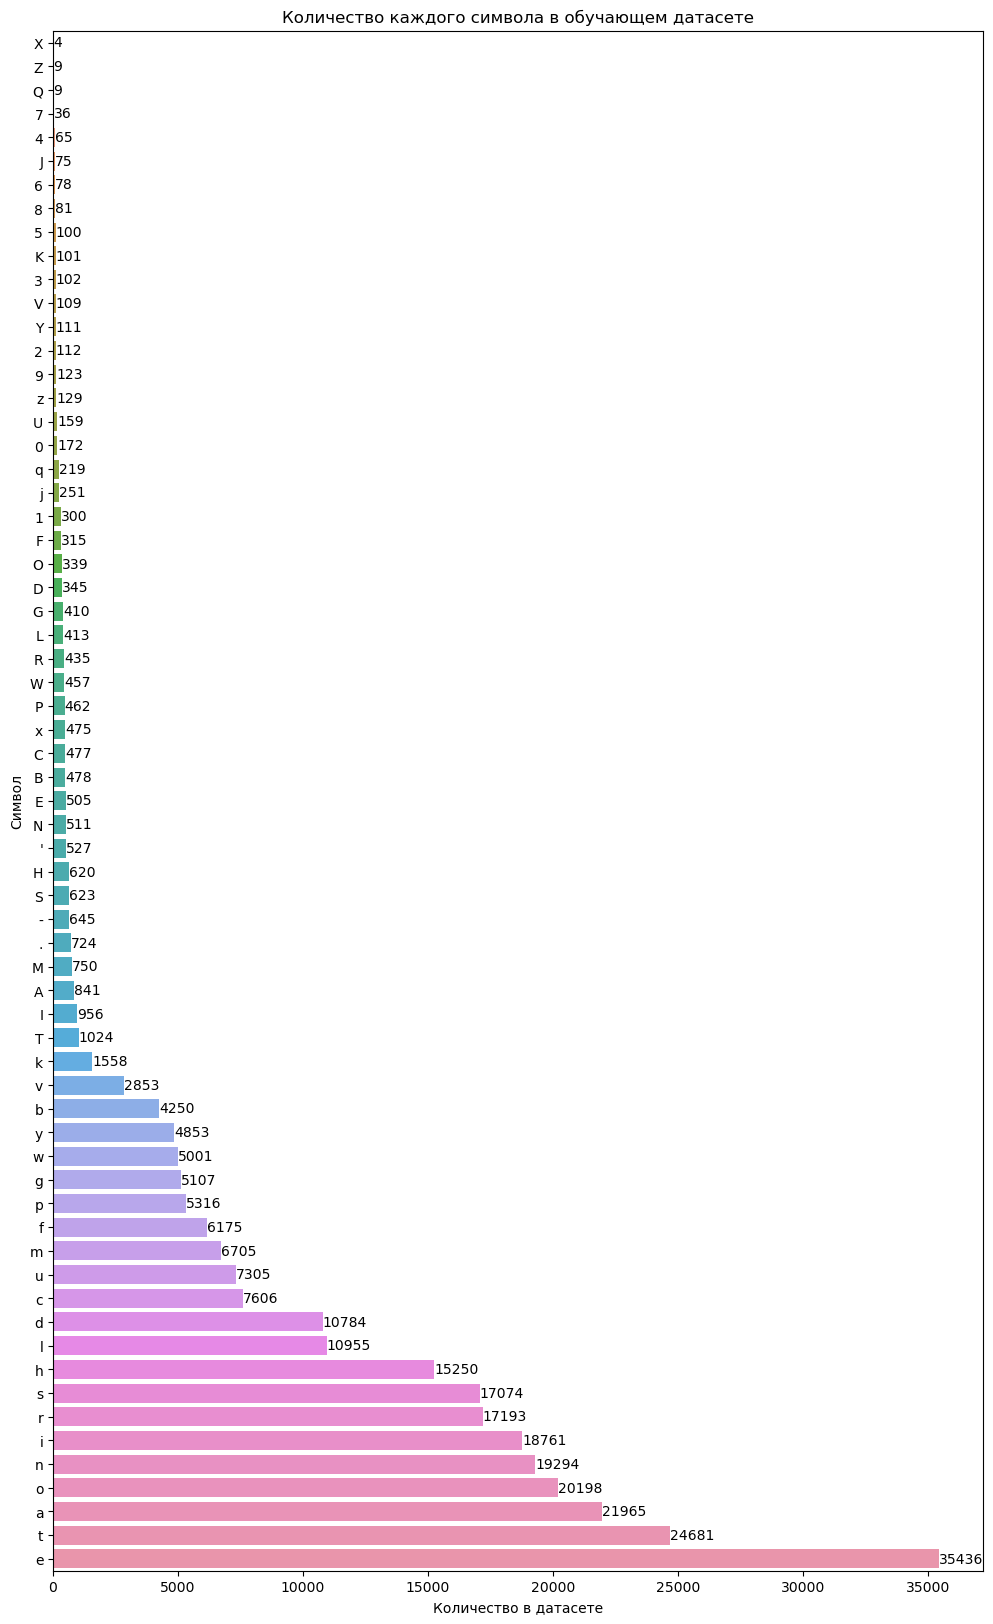

In [3]:
show_dir_info('/home/astrashnov/data/iam_data/train_words')

##### Тестовый датасет:

Word number: 17755
Max word length: 21
Alphabet size: 63
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyz


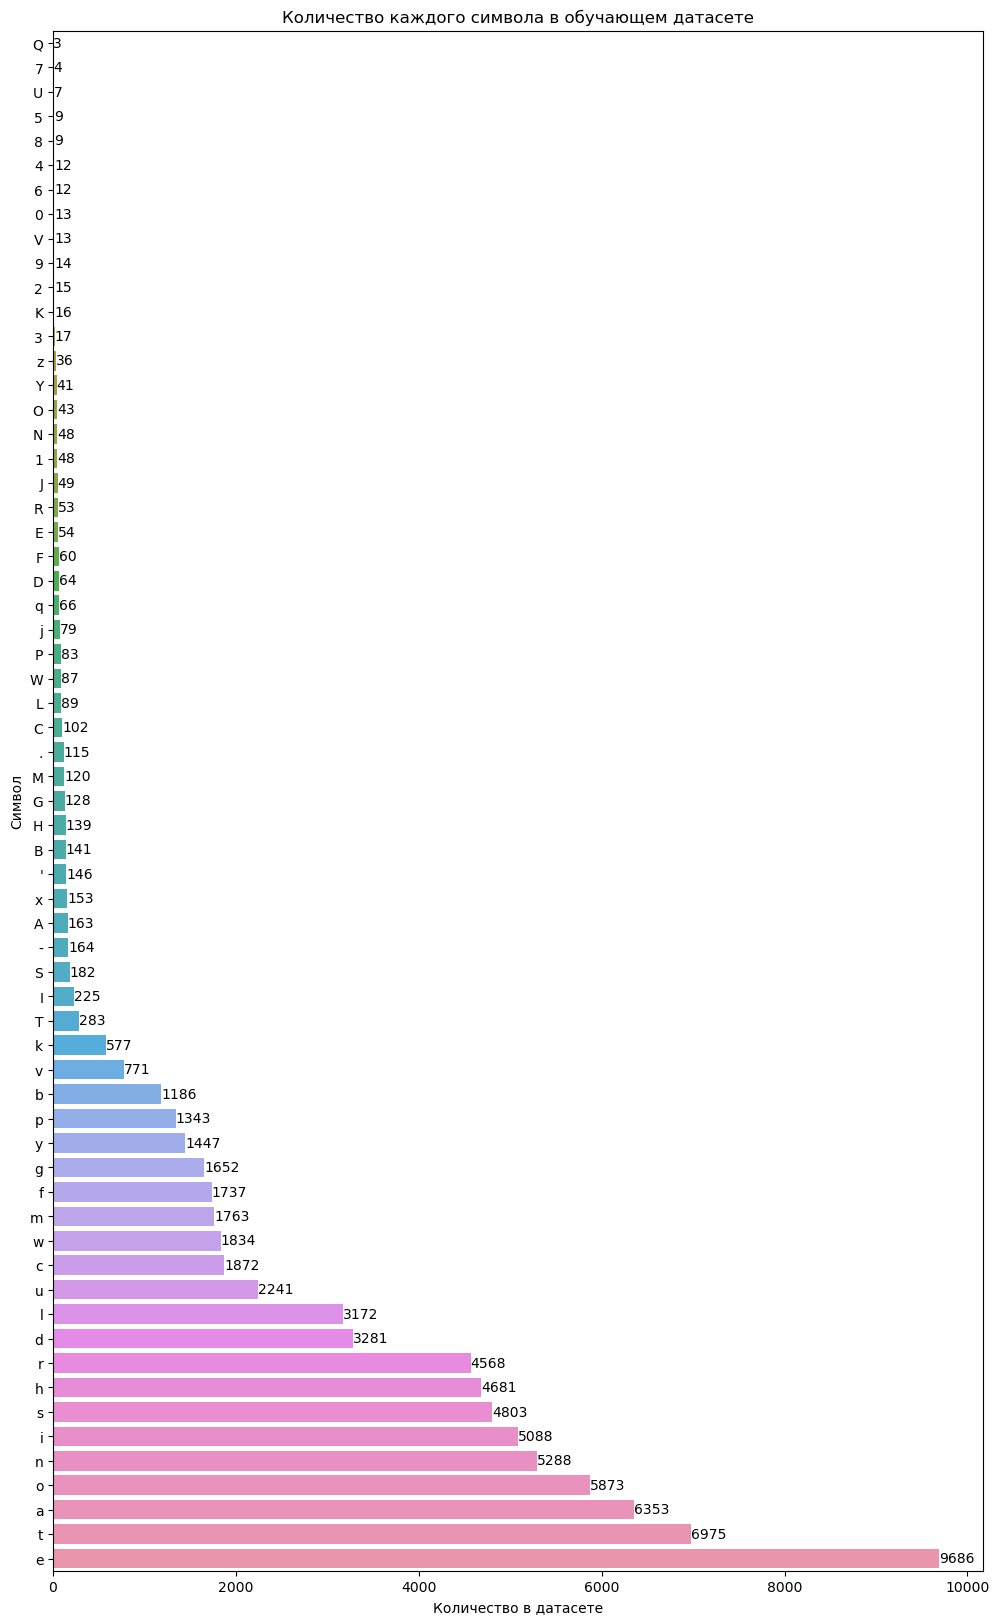

In [4]:
show_dir_info('/home/astrashnov/data/iam_data/test_words')

Видно, что распределения символов в обучающем и тестовом датасетах похожи.

Посмотрим теперь на некотрые изображения из обучающего датасета:

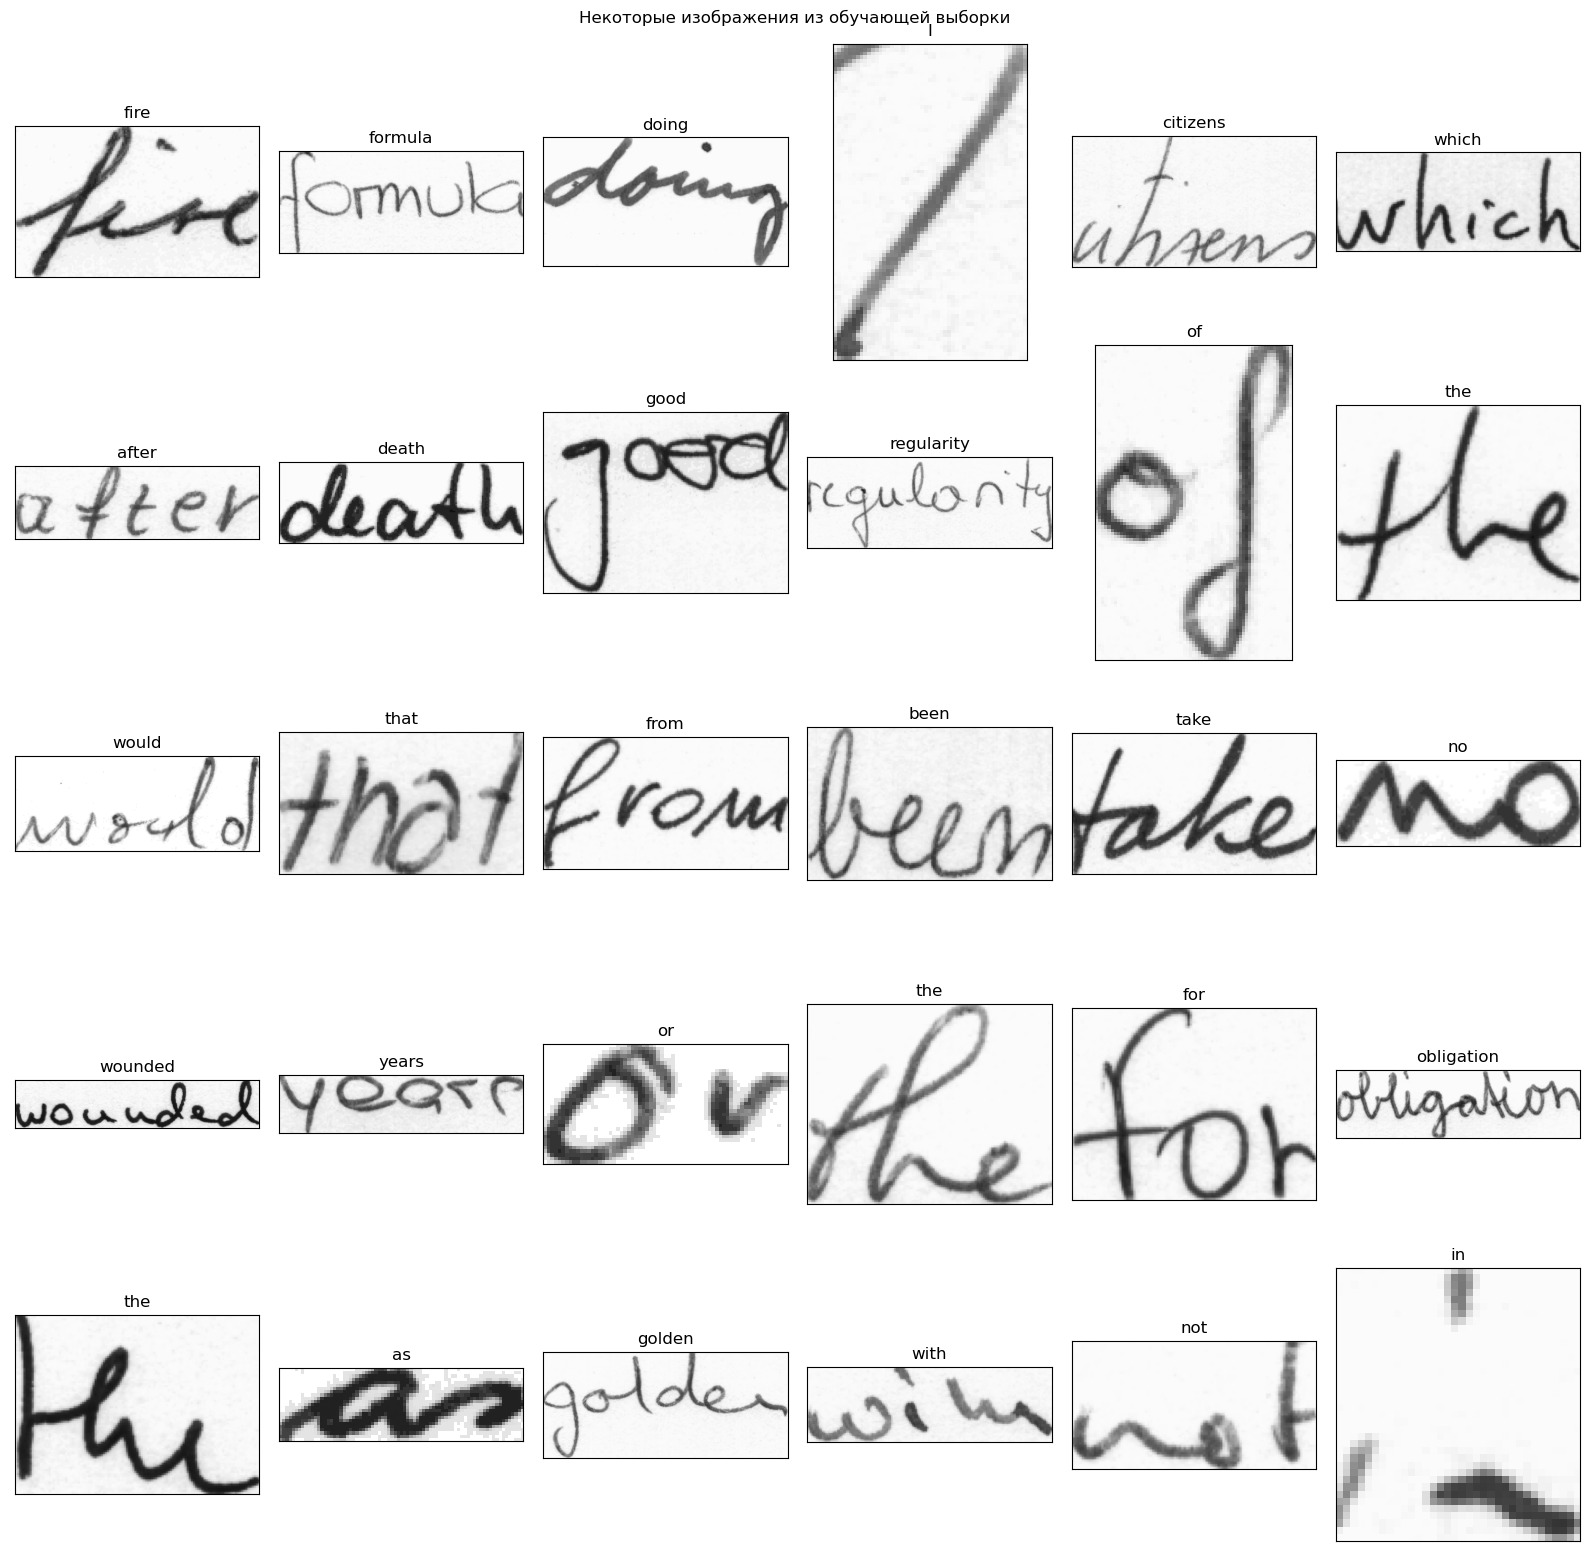

In [5]:
train_dir = '/home/astrashnov/data/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

## Тестирование моделей

In [6]:
def get_dict(filename, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        try:
            img_path, label = l.split()[:2]
        except:
            img_path, label = l.strip(), ''
        if not set(label.lower()).issubset(alphabet):
            continue
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [7]:
def general_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'LC + UC, short words',
             'MC, all words', 'MC, long words', 'MC, short words')
    if alphabet == alphabet.lower():
        cases = cases[3:]
        
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    short_num = 0
    all_num = 0
    long_char = 0
    short_char = 0
    all_char = 0

    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
            continue
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)
            
            suf = ', short words'
            if is_long:
                suf = ', long words'
            correct_num[case + suf] += is_correct
            edit_dis[case + suf] += cur_edit_dis
            norm_edit_dis[case + suf] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1
        else:
            short_char += len(target)
            short_num += 1
            
    case_function = lambda case, all_, short, long: max(all_ if (case[-9:-6] == 'all') else (long if (case[-10:-6] == 'long') else short), 1)
    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / case_function(case, all_num, short_num, long_num)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / case_function(case, all_num, short_num, long_num)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / case_function(case, all_char, short_char, long_char)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [8]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)
    lower_alphabet = ''.join(set(alphabet.lower()))

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in lower_alphabet}, 'ins': {char: 0 for char in lower_alphabet}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in lower_alphabet} for sym in lower_alphabet})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    if alphabet == alphabet.lower():
        cases = cases[2:]
    
    mistakes = []
    for name, target in target_dict.items():
        try:
            pred = pred_dict[name]
        except KeyError:
            print(name + " isn't predicted")
            continue
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)
        else:
            pred, target = pred.lower(), target.lower()
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

### Модель, обученная на словаре LC + UC + Num + Pc3

In [9]:
%%time
%env CUDA_VISIBLE_DEVICES=3
!python tools/inference.py configs/cstr_original_LC_UC_Num_Pc3.py workdir/cstr_original_LC_UC_Num_Pc3/best_norm.pth /home/astrashnov/data/iam_data/test_words/ workdir/predictions_cstr_original_LC_UC_Num_Pc3.txt > /dev/null

env: CUDA_VISIBLE_DEVICES=3
/home/astrashnov/anaconda3/envs/vedastr/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
CPU times: user 4.96 s, sys: 808 ms, total: 5.77 s
Wall time: 5min 46s


Получим предсказания обученной модели, а также правильные метки:

In [10]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [11]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.789974655026753
Accuracy (LC + UC, long words): 0.2706552706552707
Accuracy (LC + UC, short words): 0.811352841142321
Accuracy (MC, all words): 0.7993241340467474
Accuracy (MC, long words): 0.27350427350427353
Accuracy (MC, short words): 0.8209699173166012
Normalized edit distance 1 (LC + UC, all words): 0.07734677311752794
Normalized edit distance 1 (LC + UC, long words): 0.28449369764861565
Normalized edit distance 1 (LC + UC, short words): 0.06881940895750804
Normalized edit distance 1 (MC, all words): 0.07282969354201413
Normalized edit distance 1 (MC, long words): 0.282803015348959
Normalized edit distance 1 (MC, short words): 0.06418597854122408
Normalized edit distance 2 (LC + UC, all words): 0.10626008878127523
Normalized edit distance 2 (LC + UC, long words): 0.2961183954303518
Normalized edit distance 2 (LC + UC, short words): 0.08583241378347045
Normalized edit distance 2 (MC, all words): 0.10240112994350282
Normalized edit distance 2 (MC, lo

In [12]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

In [13]:
tables['LC + UC, all words']

'   -  .  0  1  2  3  4  5  6  7  8  9    a   b   c   d    e   f   g  \
del   6   6  5  1  1  0  2  4  3  2  2  2  2   35   8  22  32   98  10  10   
ins  16  31  7  0  5  0  1  1  0  1  0  0  1   66  15  72  55  167  30  28   
'     0   0  0  0  0  0  0  0  0  0  0  0  0    2   0   0   0    1   0   0   
-     0   0  0  0  0  0  0  0  0  0  0  1  0    3   1   4   2    4   0   1   
.     0   2  0  0  1  2  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
0     0   0  1  0  0  0  0  0  0  0  0  0  0    1   0   1   1    0   0   0   
1     0   0  0  0  0  0  0  0  1  0  0  0  0    0   0   0   0    0   0   0   
2     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
3     0   0  0  0  0  1  0  0  0  0  0  2  0    0   0   0   0    0   0   0   
4     0   0  0  0  2  0  0  0  0  0  0  0  2    1   0   0   0    0   0   0   
5     0   1  0  1  1  0  0  0  0  0  0  1  0    0   0   0   0    0   0   0   
6     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
7     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
8     0   1  0  0  0  0  0  0  0  1  0  0  0    0   0   0   0    1   0   0   
9     0   0  0  1  0  0  2  0  1  0  0  1  0    0   0   0   0    0   0   0   
a     1   3  0  0  0  0  0  0  0  0  0  0  1    0   5  13  13   29   7  10   
b     0   1  0  0  3  0  0  0  0  3  0  0  0    1   0   2   6    0   3   1   
c     1   0  0  0  0  0  0  0  0  0  0  0  0   15   1   0  13   17   1   1   
d     1   3  0  0  0  0  0  0  0  0  0  0  0    7   4  16   0   21   0   3   
e     0   8  0  0  0  0  0  0  0  0  0  0  0   66   7  45  36    0   5   7   
f     1   1  0  0  0  0  0  1  0  0  0  0  0    1   2   4   1    7   0   2   
g     0   1  1  0  0  0  0  0  0  0  0  0  0    6   0   4   1   12   7   0   
h     0   1  0  0  0  0  0  0  0  0  0  0  0    3  13   3   4    5   1   1   
i     5   4  1  0  1  0  1  0  0  0  0  0  0   21   9  25   7   29   2  14   
j     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   3   2   
k     0   0  0  0  0  0  0  0  0  0  0  0  0    1   2   1   0    7   3   0   
l     3   2  1  0  2  0  0  0  0  0  0  0  0   23  24   7  23   39  16   2   
m     0   2  0  0  0  0  0  1  0  0  0  0  0    6   2   3   1   14   1   2   
n     2   7  6  0  0  0  0  0  0  0  0  0  0   32   1  14   4   28   0  17   
o     2   6  1  2  0  0  1  0  0  0  0  0  0  131   5   8   9   40   4   0   
p     0   1  0  1  0  0  0  0  0  0  0  0  0    3   2   0   2    7  12   5   
q     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   1   
r     3   6  0  1  0  0  0  1  0  0  0  0  0   24   4  11   4   38   4   3   
s     7   1  0  0  0  1  1  0  3  0  0  1  0   17  11  10  11   41   4   8   
t     2   4  0  0  1  0  0  1  0  1  1  0  0   22   8  12  14   39  38   3   
u     1   1  0  0  0  0  0  1  0  1  0  0  0   22   3   0   0   19   1   2   
v     0   0  0  0  0  0  0  0  0  0  0  0  0    1   0   7   0    6   0   0   
w     1   0  0  0  0  0  0  0  0  0  0  0  0    1   1   0   0    0   0   0   
x     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
y     0   2  0  0  0  0  0  0  0  0  0  0  0    8   0   2   7    8   1  22   
z     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   0   0   
A     0   1  0  0  0  0  0  0  0  0  0  0  0    5   0   0   0    0   0   0   
B     0   0  0  0  0  0  4  0  0  0  0  0  0    0   3   0   0    0   0   0   
C     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   6   0    0   0   0   
D     0   0  0  0  0  0  0  0  0  0  0  0  0    1   0   0   0    0   0   0   
E     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    3   0   0   
F     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0    0   5   0   
G     0   0  0  0  0  0  0  0  0  3  0  0  0    0   1   0   0    0   1   1   
H     0   0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   1    0   1   0   
I     0   0  1  0  3  0  0  0  0  0  0  0  1    2   0   0   0    3   0   0   
J     0   0  0  0  0  0  0  

In [14]:
tables['MC, all words']

a   h  5  3    o   -   k  8    e   w   d  7   g  z  1  6  9   '   b  \
del   40  13  3  3   32   7   5  1  103   4  38  1  12  7  1  1  2   5   9   
ins   67  36  0  1   75  31  12  0  167  16  56  0  29  6  5  1  1  16  17   
a      0   8  0  0  108   3   3  0   29  10  16  0  10  0  0  0  1   1   5   
h      5   0  0  0    5   1   6  0    6   6   5  0   2  0  0  0  0   0  13   
5      0   0  0  0    0   1   0  1    0   0   0  0   0  0  1  0  0   0   0   
3      0   0  0  0    0   0   0  2    0   0   0  0   0  0  0  0  0   0   0   
o    132   9  0  1    0   6   3  0   41  10  10  0   0  0  0  0  0   2   5   
-      4   3  0  0    3   0   0  1    4   0   2  0   1  0  0  0  0   0   1   
k      1   9  0  0    2   0   0  0    7   0   0  0   0  0  0  0  0   0   2   
8      0   0  0  0    0   1   0  0    1   0   0  0   0  0  0  1  0   0   0   
e     65  17  0  0   42   7  13  0    0   8  36  0   7  2  0  0  0   0   7   
w      1   3  0  0    5   0   1  0    0   0   0  0   0  0  0  0  0   1   2   
d      9   9  0  0   11   3   3  0   21   2   0  0   3  0  0  0  0   1   6   
7      0   0  0  0    0   0   0  0    0   0   0  0   0  0  0  0  0   0   0   
g      7   2  0  0    5   1   0  0   12   1   1  0   0  5  0  3  0   0   1   
z      0   0  0  0    0   0   0  0    0   0   0  0   0  0  0  0  0   0   0   
1      0   0  1  0    0   0   0  0    0   0   0  0   0  0  0  0  0   0   0   
6      0   0  0  0    0   0   0  0    0   0   0  0   1  0  0  0  0   0   0   
9      0   0  1  2    0   0   0  1    0   0   0  0   0  0  0  0  0   0   0   
'      2   1  0  0    0   0   0  0    1   0   0  0   0  0  0  0  0   0   0   
b      1  13  0  4    4   1   6  0    1   3   6  0  14  0  3  3  0   0   0   
f      3   6  0  0    1   1   2  0    9   0   2  0   8  0  0  0  0   1   3   
s     17  16  3  1   19   1   2  1   42   4  12  0   8  4  0  0  0   7  12   
i     27  11  0  1   15   5   9  0   30   6   7  0  14  6  4  0  1   5   9   
t     28  50  0  0   15   4  37  0   40   4  14  1   3  1  1  1  0   2   8   
.      0   0  0  0    0   2   2  0    1   0   1  0   0  0  1  0  0   0   0   
r     24   8  0  0   23   7   5  0   38  24   5  0   3  2  0  0  0   3   4   
x      0   0  0  0    0   0   1  0    0   0   0  0   0  0  0  0  0   0   0   
l     23  39  0  0    8   2  23  0   39   3  23  0   2  0  3  0  0   3  24   
0      1   0  0  0    4   0   0  0    0   0   1  0   0  0  0  0  0   0   0   
2      1   0  0  0    0   0   0  0    0   0   0  0   0  0  0  0  0   0   0   
j      0   0  0  0    0   0   0  0    0   0   0  0   2  0  0  0  0   0   0   
c     15   3  0  0    9   0   1  0   20  11  13  0   4  0  0  0  0   1   1   
u     22   4  0  0   16   1   1  0   20  22   0  0   2  0  1  1  0   1   3   
y      8   1  0  0    4   3   3  0    8   0   7  0  22  1  0  0  0   0   0   
p      3   2  0  1    4   1   0  0    8   0   4  0   6  0  0  0  0   0   4   
m      7   7  0  0    4   2   1  0   15  10   1  0   2  0  0  0  0   0   2   
v      1   0  0  0    2   0   0  0    6   6   0  0   0  1  0  0  0   0   0   
4      1   0  0  0    0   0   0  0    0   0   0  0   0  0  2  0  2   0   0   
q      0   0  0  0    0   0   0  0    1   0   0  0   1  0  0  0  0   0   0   
n     32   8  0  0   13   7   5  0   28  21   4  0  17  1  0  0  0   2   1   

      f    s   i    t  .    r   x   l  0  2  j   c   u   y   p    m   v  4  q  \
del  15   60  50   61  4   54   5  51  1  0  4  26  18  26  13   13   8  5  6   
ins  30  177  81  120  7  177   4  92  1  0  1  77  49  39  17   21  30  1  0   
a     7   16  23   27  0   28   2  23  0  0  0  14  36   7   8    9   2  0  2   
h     2    2   3   25  0   12   0  20  0  0  0   3   2   0   0    5   0  0  0   
5     0    0   1    0  0    0   0   0  1  0  0   0   0   1   0    0   0  0  0   
3     0    1   0    0  0    0   0   0  0  1  0   0   0   0   0    0   0  0  0   
o     4   32  18    7  1   27   2   7  2  0  0   8  19   1   4    6   4  0  1   
-     0    2   4    3  0    5   0   3  0  0  0   4   2   0   0    2   0  0  0   
k

In [15]:
tables['LC + UC, long words']

'   -  .  0  1  2  3  4  5  6  7  8  9   a  b   c   d   e  f  g   h   i  \
del  4   5  4  1  0  0  2  3  2  2  2  2  2   7  3   6   6  29  5  5   2  13   
ins  3  11  0  0  0  0  0  0  0  0  0  0  0  28  8  27  17  56  9  4   8  32   
'    0   0  0  0  0  0  0  0  0  0  0  0  0   1  0   0   0   1  0  0   0   0   
-    0   0  0  0  0  0  0  0  0  0  0  0  0   3  1   4   2   3  0  1   2   4   
.    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
0    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
1    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
2    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
3    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
4    0   0  0  0  0  0  0  0  0  0  0  0  0   1  0   0   0   0  0  0   0   1   
5    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
6    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
7    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
8    0   1  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   1  0  0   0   0   
9    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
a    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   3   3   7  3  2   2   8   
b    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   1   2   0  0  0   1   0   
c    0   0  0  0  0  0  0  0  0  0  0  0  0   3  0   0   2   6  0  1   1   4   
d    0   2  0  0  0  0  0  0  0  0  0  0  0   2  1   4   0  12  0  0   2   2   
e    0   4  0  0  0  0  0  0  0  0  0  0  0  15  1  17   9   0  1  4   3  11   
f    0   0  0  0  0  0  0  1  0  0  0  0  0   0  0   3   1   3  0  2   3   0   
g    0   1  0  0  0  0  0  0  0  0  0  0  0   2  0   1   0   1  0  0   0   5   
h    0   1  0  0  0  0  0  0  0  0  0  0  0   0  1   1   1   1  0  1   0   1   
i    0   3  0  0  0  0  0  0  0  0  0  0  0  14  4   9   5   8  0  6   2   0   
j    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  1   0   0   
k    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
l    0   1  0  0  0  0  0  0  0  0  0  0  0   9  9   2   3  10  1  1   3   7   
m    0   1  0  0  0  0  0  0  0  0  0  0  0   4  1   1   0   7  0  1   0   2   
n    1   4  0  0  0  0  0  0  0  0  0  0  0   8  0   5   1   7  0  6   1   8   
o    0   5  0  2  0  0  0  0  0  0  0  0  0  23  1   2   2  13  3  0   0   8   
p    0   1  0  0  0  0  0  0  0  0  0  0  0   2  0   0   1   1  3  0   0   0   
q    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
r    0   3  0  0  0  0  0  0  0  0  0  0  0  12  3   7   3  16  1  2   1   6   
s    2   0  0  0  0  0  0  0  0  0  0  0  0   8  3   5   3   9  1  1   1  12   
t    1   3  0  0  0  0  0  0  0  0  0  0  0   6  3   9   4  15  3  2  10  14   
u    0   0  0  0  0  0  0  0  0  0  0  0  0   3  2   0   0   2  1  1   0  10   
v    0   0  0  0  0  0  0  0  0  0  0  0  0   1  0   3   0   2  0  0   0   0   
w    0   0  0  0  0  0  0  0  0  0  0  0  0   0  1   0   0   0  0  0   0   0   
x    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
y    0   0  0  0  0  0  0  0  0  0  0  0  0   2  0   1   1   2  0  5   0   2   
z    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
A    0   1  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
B    0   0  0  0  0  0  0  0  0  0  0  0  0   0  1   0   0   0  0  0   0   0   
C    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   1   0   0  0  0   1   0   
D    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
E    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
F    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
G    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
H    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0   0   0   0  0  0   0   0   
I    

In [16]:
tables['MC, long words']

a   h  5  3   o   -  k  8   e  w   d  7  g  z  1  6  9  '  b  f   s   i  \
del  10   4  2  3  13   6  4  1  33  4   9  1  6  5  0  1  2  3  3  7  11  17   
ins  28   8  0  0  26  11  2  0  56  5  17  0  4  4  0  0  0  3  8  9  41  32   
a     0   2  0  0  15   0  2  0   7  2   3  0  2  0  0  0  0  0  0  3   7   8   
h     0   0  0  0   2   1  0  0   1  0   1  0  1  0  0  0  0  0  1  0   0   1   
5     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
3     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   1   0   
o    23   0  0  0   0   5  0  0  13  0   3  0  0  0  0  0  0  0  1  3   6   8   
-     4   2  0  0   1   0  0  0   3  0   2  0  1  0  0  0  0  0  1  0   2   4   
k     0   0  0  0   1   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
8     0   0  0  0   0   1  0  0   1  0   0  0  0  0  0  0  0  0  0  0   0   0   
e    14   3  0  0  16   3  2  0   0  1   9  0  4  1  0  0  0  0  1  1  15  11   
w     0   0  0  0   1   0  0  0   0  0   0  0  0  0  0  0  0  0  1  0   0   0   
d     2   2  0  0   3   2  1  0  12  1   0  0  0  0  0  0  0  0  2  0   3   2   
7     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
g     2   0  0  0   3   1  0  0   1  1   0  0  0  1  0  0  0  0  0  0   0   5   
z     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
1     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
6     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
9     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
'     1   0  0  0   0   0  0  0   1  0   0  0  0  0  0  0  0  0  0  0   3   1   
b     0   1  0  0   2   0  0  0   0  1   2  0  1  0  0  0  0  0  0  0   1   0   
f     0   3  0  0   0   0  0  0   3  0   1  0  2  0  0  0  0  0  0  0   1   0   
s     8   2  0  0   5   0  1  0   9  0   3  0  1  2  0  0  0  2  3  1   0  12   
i    14   2  0  0   7   4  2  0   8  2   5  0  6  0  0  0  0  0  4  0  10   0   
t     6  12  0  0   6   3  4  0  16  0   4  0  2  0  0  0  0  1  3  5  12  15   
.     0   0  0  0   0   0  0  0   1  0   0  0  0  0  0  0  0  0  0  0   0   0   
r    12   1  0  0  10   4  1  0  16  2   4  0  2  0  0  0  0  0  3  1   9   5   
x     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
l     9   3  0  0   6   1  0  0  10  2   3  0  1  0  0  0  0  0  9  1   3   8   
0     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
2     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
j     0   0  0  0   0   0  0  0   0  0   0  0  1  0  0  0  0  0  0  0   0   0   
c     3   1  0  0   4   0  0  0   6  1   2  0  1  0  0  0  0  0  0  0   5   4   
u     3   0  0  0   4   0  0  0   2  1   0  0  1  0  0  0  0  0  2  1   0  10   
y     2   0  0  0   1   1  2  0   2  0   1  0  5  0  0  0  0  0  0  0   3   2   
p     2   0  0  0   4   1  0  0   1  0   1  0  0  0  0  0  0  0  0  3   6   1   
m     4   0  0  0   1   1  0  0   7  0   0  0  1  0  0  0  0  0  1  0   5   2   
v     1   0  0  0   1   0  0  0   2  0   0  0  0  0  0  0  0  0  0  0   1   0   
4     1   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   1   
q     0   0  0  0   0   0  0  0   0  0   0  0  0  0  0  0  0  0  0  0   0   0   
n     8   1  0  0   3   4  0  0   7  4   1  0  6  0  0  0  0  1  0  0  16   8   

      t  .   r  x   l  0  2  j   c   u  y  p   m  v  4  q   n  
del  17  3   7  2  13  1  0  4   9   5  9  8   5  6  4  6  17  
ins  30  0  45  1  27  0  0  1  28  15  9  8   9  7  0  0  42  
a    11  0   8  0   4  0  0  0   3  11  0  3   2  1  0  0  10  
h     8  0   1  0   3  0  0  0   1   2  0  0   2  0  0  0   1  
5     0  0   0  0   0  0  0  0   0   0  1  0   0  0  0  0   0  
3     0  0   0  0   0  0  0  0   0   0  0  0   0  0  0  0   0  
o     3  0   9  1   1  2  0  0   2   6  1  0   3  2  0  0  12  
-     3  0   5  0   3  0  0  0   4   1  0  0   1  0  0  0   1  
k     0  0   0  0   0  0  0

Посмотрим на некоторые неправильно распознанные изображения:

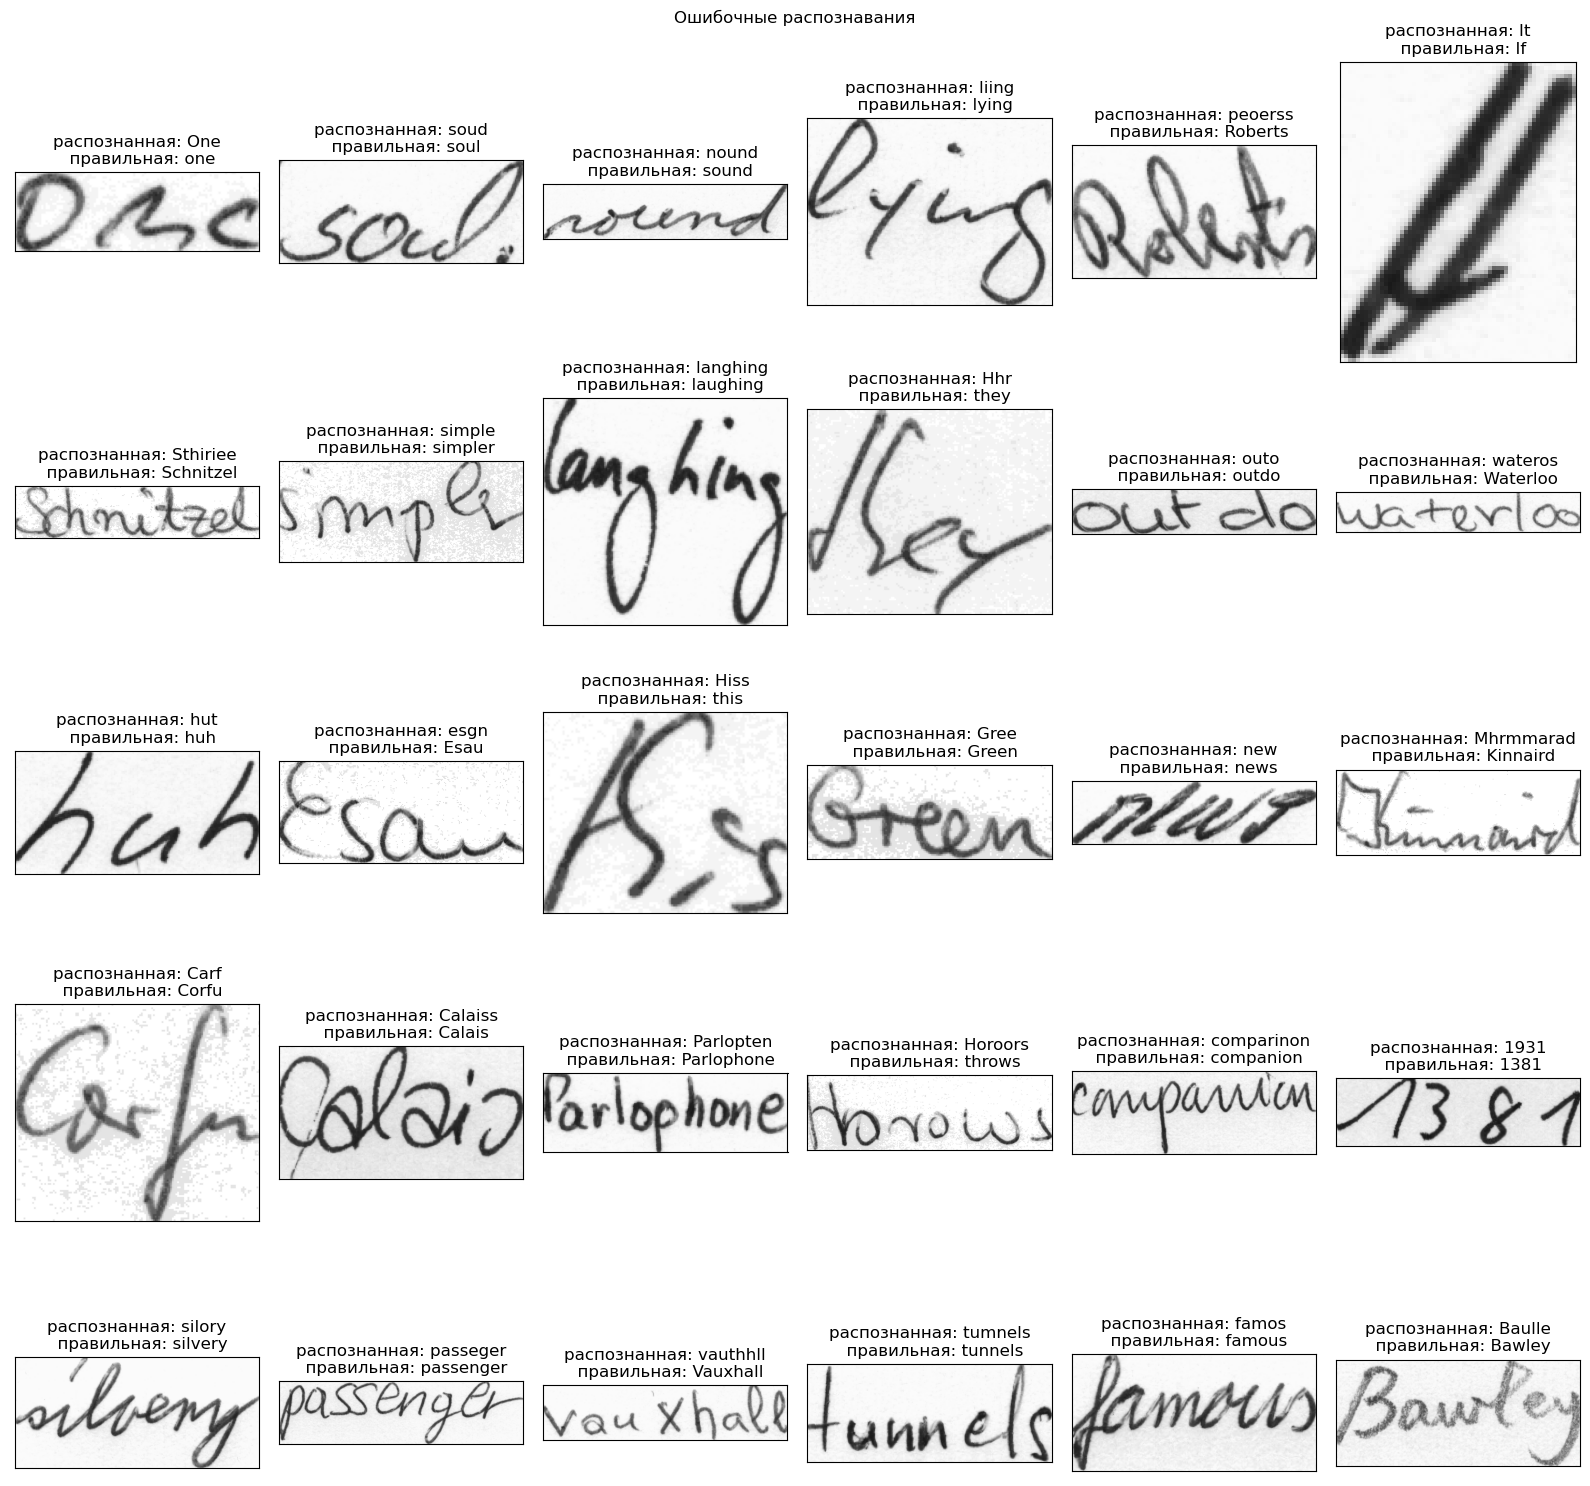

In [17]:
test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, обученная на словаре MC

In [18]:
%%time
%env CUDA_VISIBLE_DEVICES=3
!python tools/inference.py configs/cstr_original_MC.py workdir/cstr_original_MC/best_norm.pth /home/astrashnov/data/iam_data/test_words/ workdir/predictions_cstr_original_MC.txt > /dev/null

env: CUDA_VISIBLE_DEVICES=3
/home/astrashnov/anaconda3/envs/vedastr/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
CPU times: user 5.71 s, sys: 945 ms, total: 6.65 s
Wall time: 6min 4s


Получим предсказания обученной модели, а также правильные метки:

In [19]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_original_MC.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [20]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.5428571428571428
Accuracy (MC, long words): 0.019543973941368076
Accuracy (MC, short words): 0.562084854287595
Normalized edit distance 1 (MC, all words): 0.21557233459181502
Normalized edit distance 1 (MC, long words): 0.5401799001758286
Normalized edit distance 1 (MC, short words): 0.20364551720993584
Normalized edit distance 2 (MC, all words): 0.2844546474317168
Normalized edit distance 2 (MC, long words): 0.5427241327526655
Normalized edit distance 2 (MC, short words): 0.25988829688459725


In [21]:
tables, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Посмотрим на посимвольные таблицы ошибок для разных длин слов:

In [22]:
tables['MC, all words']

a    h    o   k    e   w    d   g  z   b   f    s    i    t    r   x  \
del  147   26  121   6  287  13  128  88  1  17  25  223  170  202  170   3   
ins  140   84  136  22  227  23   61  55  7  27  38  281  139  176  293   2   
a      0   52  347  17  136  42   51  27  5  26  12   90  102   64   91   3   
h     19    0    8  11   21  23   15   4  0  17   4   10   13   72   25   1   
o    258   28    0   2  104  19   10  12  1  16  10   60   74   28  113   1   
k      2   14    0   0   13   0    4   0  0   4   3    5    3   36    6   0   
e    293   94  185  54    0  27  137  47  2  39  30  168  122  131  268  12   
w      8    3    8   0    7   0    0   0  0   0   0   12    4    1   23   1   
d     67   27   42  20  156   9    0   3  1  28   1   42   28   80   43   0   
g     33    5   19   1   25   3    5   0  4   2  13   32   21   12   27   0   
z      0    0    0   0    0   0    1   0  0   0   0    0    0    0    0   0   
b      8   29    5   6   11   3    4   9  0   0   9    6    8   20   10   0   
f      5   17    3   1   12   0    2   7  0   7   0   12    5   69   12   0   
s     76   44   94  15  165  36   48  30  2  35  12    0   90   94  192  20   
i     95   53   67  23   91  18   30  46  4  17  18  100    0  110  104   3   
t     71  171   58  51  112  10   57   4  1  40  98  140  101    0  103   5   
r     72   19   73   4  116  27   16  13  1   7   8  119   70   50    0   6   
x      2    0    0   1    1   0    2   0  0   0   2    6    0    1    2   0   
l     76  115   38  69  150  15   68  15  0  92  39   49   73  171   63   3   
j      0    0    0   0    0   1    1   0  0   0   1    1    1    1    1   0   
c     88   20   59  11   92  41   73  17  3  11   4   62   29   60   65   5   
u     54   11   35   1   36  36    4   5  0   4   3   13   56   11   40   1   
y     18   14    8   2   20   2    9  61  0   4   7   17   11   22   21   1   
p      9    1    7   0    8   1    7  22  0   3  28   15    8   14   18   0   
m     13   18    8   1   14  33    1   0  0   3   4   15   14   24   34   0   
v      3    0   12   2   12  14    0   0  1   0   2   10   12    4   28   4   
q      0    0    0   0    0   0    0   0  0   0   2    0    0    0    0   0   
n    100   32   56   2   98  92   33  64  4  11   3  140   72   58  188   5   

       l   j    c    u   y   p    m   v   q    n  
del  142   0  104   40  90  16   25  18   0  225  
ins  135   1   94   84  36  18   37  40   4  152  
a     77   0   46  117  18  22   46  20   4  150  
h     24   1    6   14   7   1   18   3   0   28  
o     17   1   18   52  10  14   26  12   0   69  
k     22   0    2    2   2   0    6   2   0    5  
e    174   5  114  155  34  67   48  57   2  170  
w      4   0    1   18   0   0   14  13   0   17  
d     84   0   46   18  13   4    8   7   2   43  
g      5  23    0   17  65  65    3   0  30   66  
z      0   0    0    0   0   0    0   0   0    0  
b     15   8    4    6   0   2    3   2   1    3  
f     17   9    2    3   3  19    0   0   0    2  
s     35  11   34   40  23  14   33  33   1  106  
i     75   6   51   55  25  15   40  40   1  179  
t    138   1   46   35  19  13   16  14   0   83  
r     43   1   34   58  40  34   51  40   1  126  
x      0   0    3    1   1   1    0  12   0    7  
l      0   4   25   35  29  13    7  19   0   20  
j      1   0    0    1   0   1    0   0   0    0  
c     35   4    0   39   5   7   31  23   1   48  
u     20   0    7    0   5   6   62  12   1   45  
y     52   1    6    3   0  18    2   2   1   41  
p      8   2    3   10  15   0    6   1   3    9  
m      3   0    8   20   2   6    0   9   0   73  
v      4   1    7   10   1   0    8   0   0   17  
q      0   0    0    0   0   2    0   0   0    0  
n     41   0   21  110  32  12  294  38   4    0

In [23]:
tables['MC, long words']

a   h   o  k   e  w   d   g  z   b  f   s   i   t   r  x   l  j   c   u  \
del  18   4  20  0  23  0  10   3  0   2  3  16  30  20  14  0   8  0   9   4   
ins  42  10  20  0  30  2  12  12  1   8  9  51  41  32  57  0  27  0  24  17   
a     0  12  37  0  34  0   2   3  1   6  4  27  25  15  15  0  16  0  19  19   
h     8   0   0  0   4  0   1   0  0   3  0   3   1   7   5  0   3  0   3   5   
o    28   4   0  0  22  1   2   3  1   2  1  14  17   6  17  0   4  0   5   4   
k     0   0   0  0   0  0   0   0  0   0  0   2   0   2   0  0   0  0   0   0   
e    50   7  25  2   0  2  18   8  1  11  6  25  30  28  40  0  29  1  29  14   
w     1   0   0  0   0  0   0   0  0   0  0   0   0   0   0  0   0  0   0   2   
d    10   2   5  0  21  1   0   0  0   4  1   9   6  15   4  0  13  0  11   4   
g     4   1   2  0   0  0   0   0  2   0  2   4   0   3   7  0   0  0   0   2   
z     0   0   0  0   0  0   0   0  0   0  0   0   0   0   0  0   0  0   0   0   
b     0   0   2  0   2  0   1   1  0   0  0   0   0   4   4  0   0  0   1   3   
f     0   0   0  1   3  0   0   0  0   0  0   1   3   4   0  0   4  0   1   1   
s    16   2   8  2  26  2  10   1  0   4  4   0  19  19  19  2   8  1  10  10   
i    31   8  26  2  35  1  11   9  1   7  5  21   0  44  18  0  17  0  13  13   
t    21  13  20  2  30  2  15   1  0  15  8  30  40   0  17  0  39  0  16  18   
r    22   3  17  0  16  0   2   2  0   3  0  18  10   9   0  1  13  0  13   7   
x     0   0   0  0   0  0   0   0  0   0  0   1   0   0   0  0   0  0   0   0   
l     9   3   3  1  22  0   7   2  0  12  2   9  14  17   6  0   0  1   3   6   
j     0   0   0  0   0  0   0   0  0   0  0   0   0   0   0  0   1  0   0   0   
c     9   1   4  0  13  0   6   0  1   4  1  16   6  11   9  0   4  2   0   8   
u     5   0   5  0   8  1   1   0  0   0  0   4   8   2   5  0   4  0   1   0   
y     0   5   0  0   2  0   1   8  0   0  1   2   2   7   1  0   9  0   0   0   
p     3   0   2  0   3  0   0   7  0   0  5   7   4   4   2  0   1  0   2   6   
m     3   2   5  0   6  1   0   0  0   2  1   4   5   3  10  0   1  0   5   4   
v     0   0   1  0   2  0   0   0  0   0  0   1   0   1   0  0   0  0   2   0   
q     0   0   0  0   0  0   0   0  0   0  0   0   0   0   0  0   0  0   0   0   
n    24   4  16  0  21  3  13  18  1   2  1  46  22  22  37  1  15  0   9  12   

      y   p   m   v  q   n  
del   4   0   4   2  0  40  
ins   4   5   6   7  2  36  
a     0   5   4   1  1  30  
h     0   1   2   0  0   2  
o     1   6   4   1  0  10  
k     0   0   0   0  0   1  
e     4  10   4   8  1  28  
w     0   0   1   0  0   1  
d     1   1   2   1  0   4  
g     7   7   0   0  1   5  
z     0   0   0   0  0   0  
b     0   1   1   0  0   0  
f     0   0   0   0  0   2  
s     7   4   7  10  1  15  
i     8   8   4   3  0  35  
t     6   5   8   7  0  32  
r     3  12   6   6  0  13  
x     0   0   0   3  0   2  
l     3   2   0   4  0   2  
j     0   0   0   0  0   0  
c     0   6   4   5  0  12  
u     0   1   6   0  0   5  
y     0   2   0   0  0   1  
p     2   0   0   0  1   0  
m     0   2   0   1  0  11  
v     0   0   1   0  0   1  
q     0   0   0   0  0   0  
n    15   5  36   6  0   0

Посмотрим на некоторые неправильно распознанные изображения:

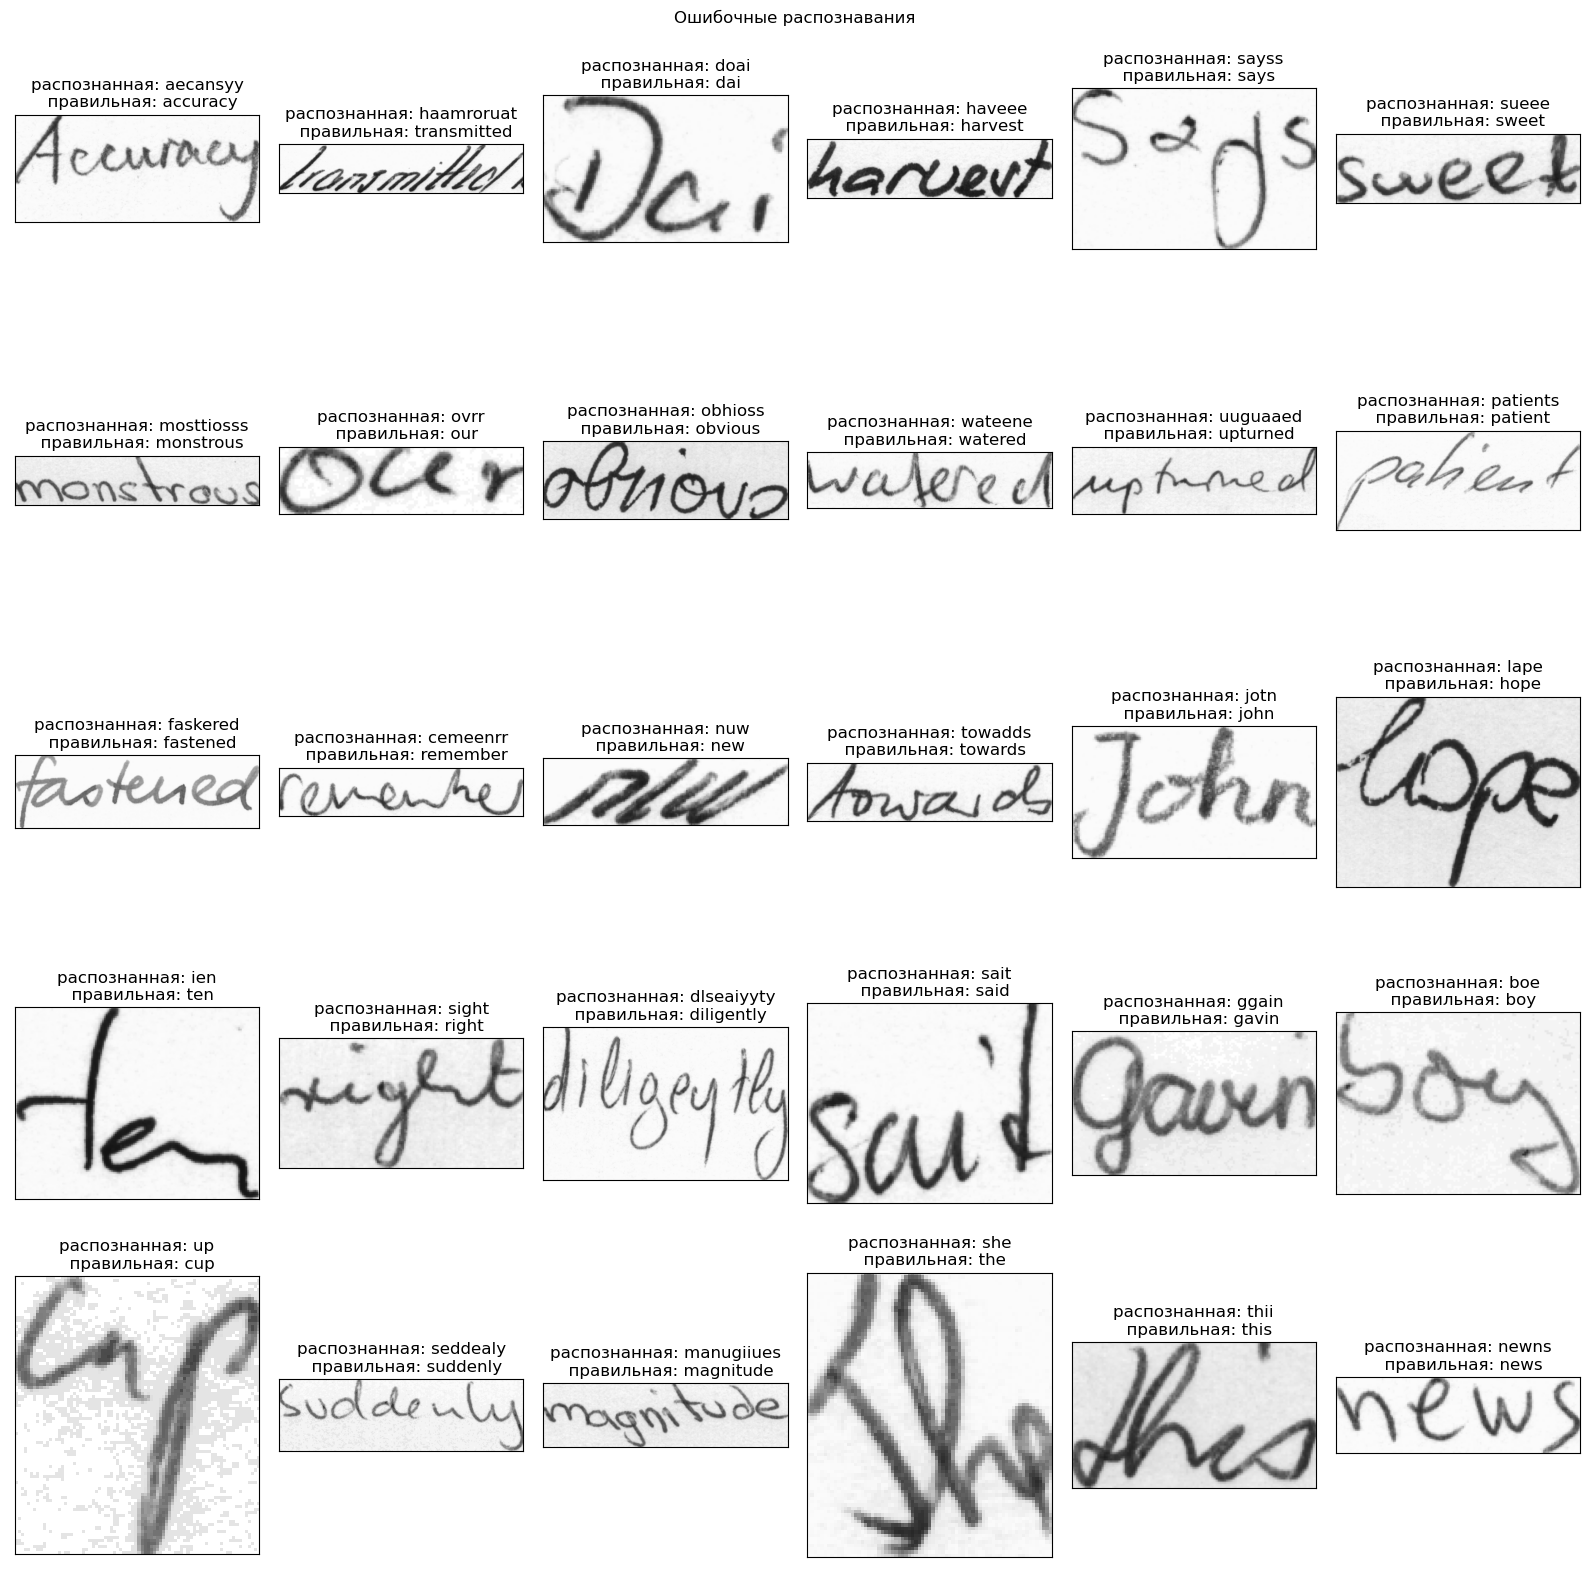

In [24]:
test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, предобученная на MJSynth + SynthText (словарь LC + UC + Num + Pc3):

In [25]:
%%time
%env CUDA_VISIBLE_DEVICES=3
!python tools/inference.py configs/cstr_MJSST+original_LC_UC_Num_Pc3.py workdir/cstr_MJSST+original_LC_UC_Num_Pc3/best_norm.pth /home/astrashnov/data/iam_data/test_words/ workdir/predictions_cstr_MJSST+original_LC_UC_Num_Pc3.txt > /dev/null

env: CUDA_VISIBLE_DEVICES=3
/home/astrashnov/anaconda3/envs/vedastr/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
CPU times: user 5.91 s, sys: 1.05 s, total: 6.96 s
Wall time: 6min 9s


Получим предсказания обученной модели, а также правильные метки:

In [26]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_MJSST+original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [27]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8665164742326106
Accuracy (LC + UC, long words): 0.6111111111111112
Accuracy (LC + UC, short words): 0.8770304345276491
Accuracy (MC, all words): 0.8763165305547733
Accuracy (MC, long words): 0.6196581196581197
Accuracy (MC, short words): 0.8868820735354483
Normalized edit distance 1 (LC + UC, all words): 0.04340056134098802
Normalized edit distance 1 (LC + UC, long words): 0.07180276073762631
Normalized edit distance 1 (LC + UC, short words): 0.04223136272629026
Normalized edit distance 1 (MC, all words): 0.038986315037837144
Normalized edit distance 1 (MC, long words): 0.0690798959955308
Normalized edit distance 1 (MC, short words): 0.03774748938649714
Normalized edit distance 2 (LC + UC, all words): 0.04864053672316384
Normalized edit distance 2 (LC + UC, long words): 0.07607425678307153
Normalized edit distance 2 (LC + UC, short words): 0.045688824326400625
Normalized edit distance 2 (MC, all words): 0.0446680790960452
Normalized edit distance 2 (MC

Посмотрим на некоторые неправильно распознанные изображения:

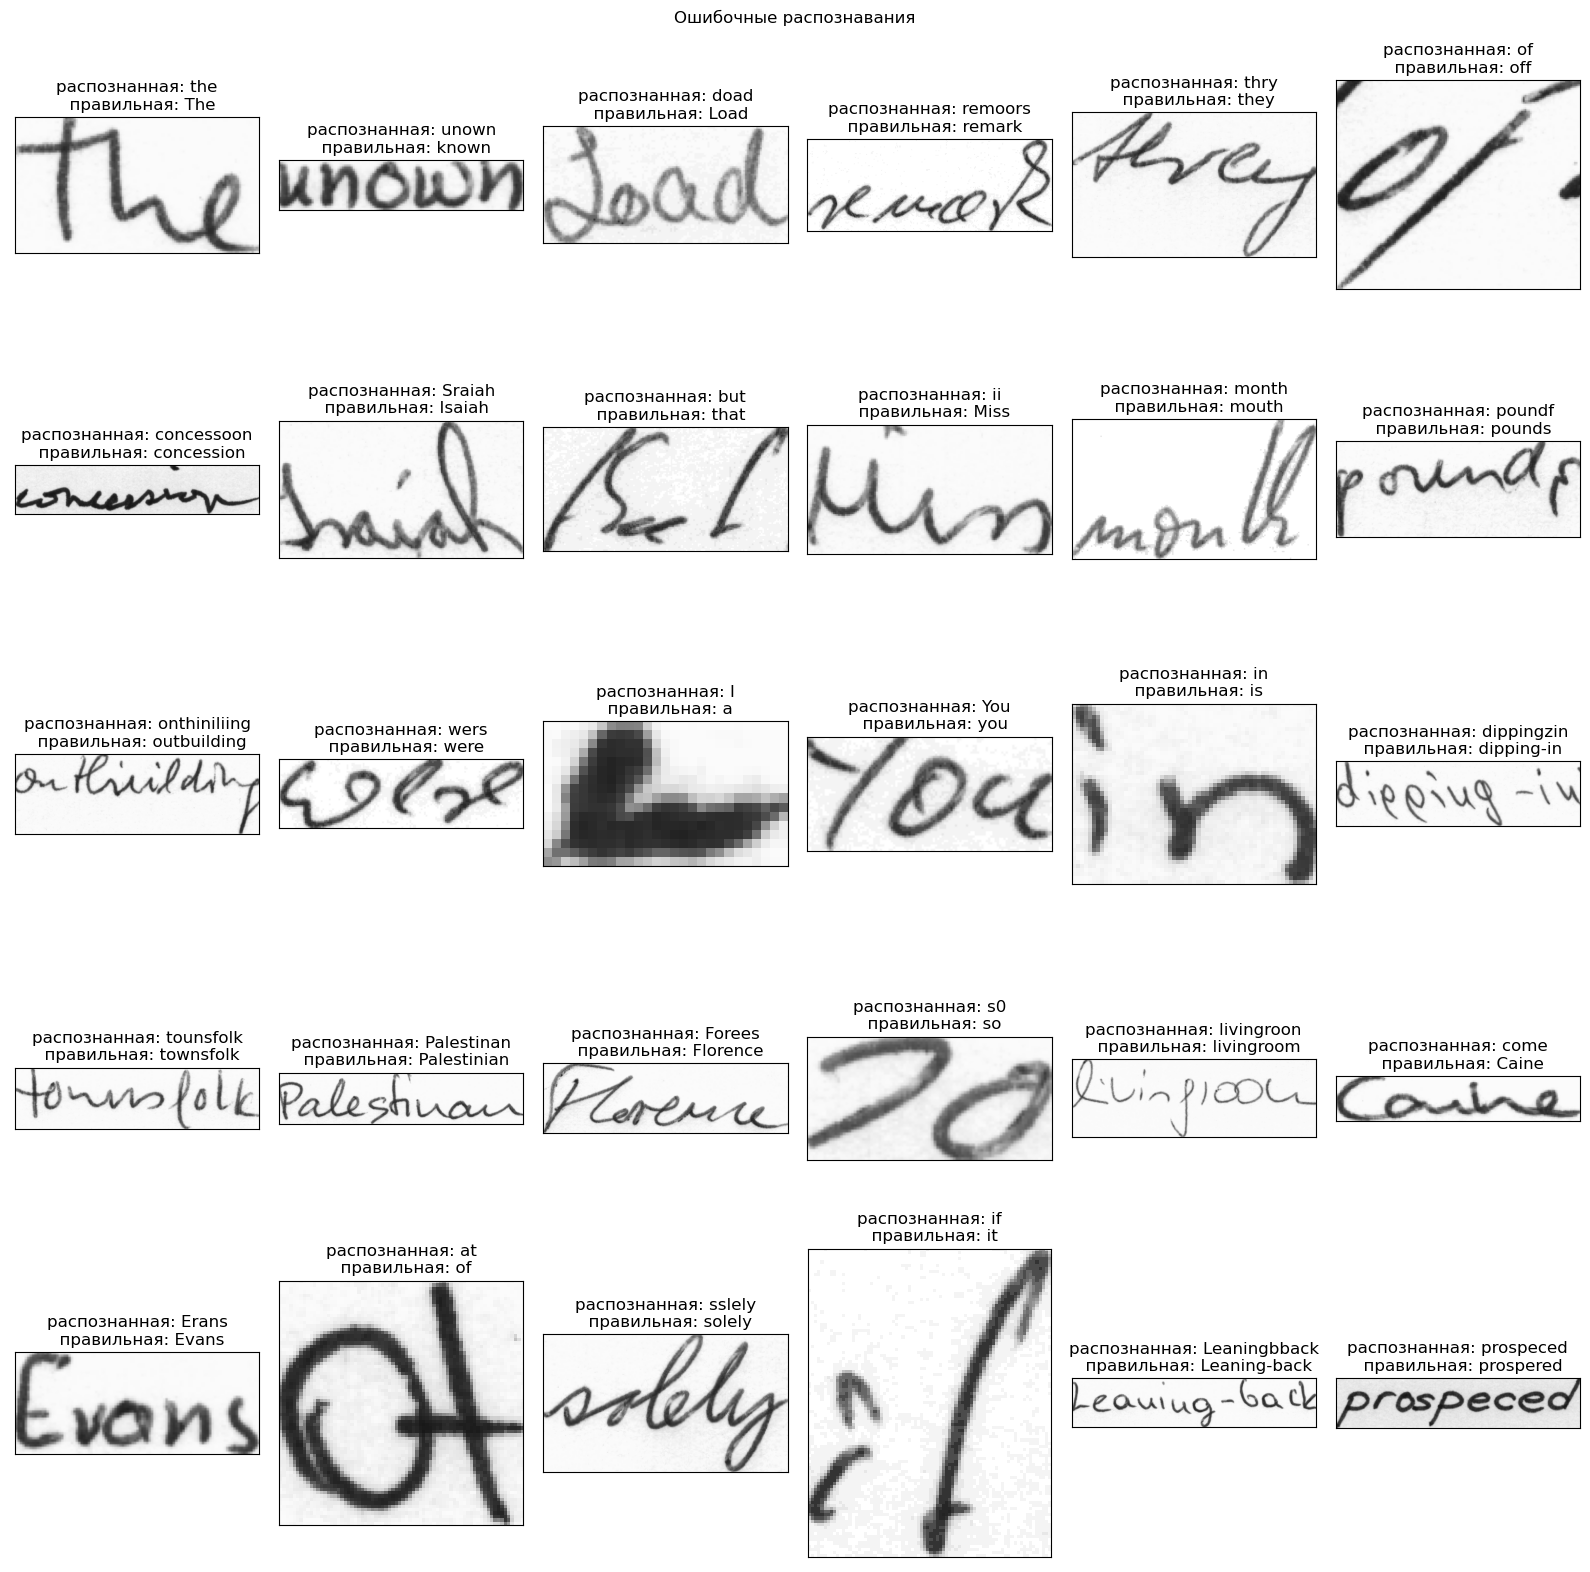

In [28]:
_, mistakes = detailed_stat(pred_file, target_file)

test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

### Модель, предобученная на MJSynth + SynthText (словарь MC):

In [29]:
%%time
%env CUDA_VISIBLE_DEVICES=3
!python tools/inference.py configs/cstr_MJSST+original_MC.py workdir/cstr_MJSST+original_MC/best_norm.pth /home/astrashnov/data/iam_data/test_words/ workdir/predictions_cstr_MJSST+original_MC.txt > /dev/null

env: CUDA_VISIBLE_DEVICES=3
/home/astrashnov/anaconda3/envs/vedastr/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
CPU times: user 5.43 s, sys: 992 ms, total: 6.43 s
Wall time: 5min 50s


Получим предсказания обученной модели, а также правильные метки:

In [30]:
pred_file = '/home/astrashnov/vedastr/workdir/predictions_cstr_MJSST+original_MC.txt'
target_file = '/home/astrashnov/data/iam_data/rec_test.txt'

##### Качество модели:

In [31]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.6368831168831168
Accuracy (MC, long words): 0.3517915309446254
Accuracy (MC, short words): 0.6473580276464604
Normalized edit distance 1 (MC, all words): 0.15843829058547668
Normalized edit distance 1 (MC, long words): 0.1798332096784865
Normalized edit distance 1 (MC, short words): 0.1576521927862364
Normalized edit distance 2 (MC, all words): 0.16613622727154148
Normalized edit distance 2 (MC, long words): 0.1799068929268659
Normalized edit distance 2 (MC, short words): 0.1648263745054066


Посмотрим на некоторые неправильно распознанные изображения:

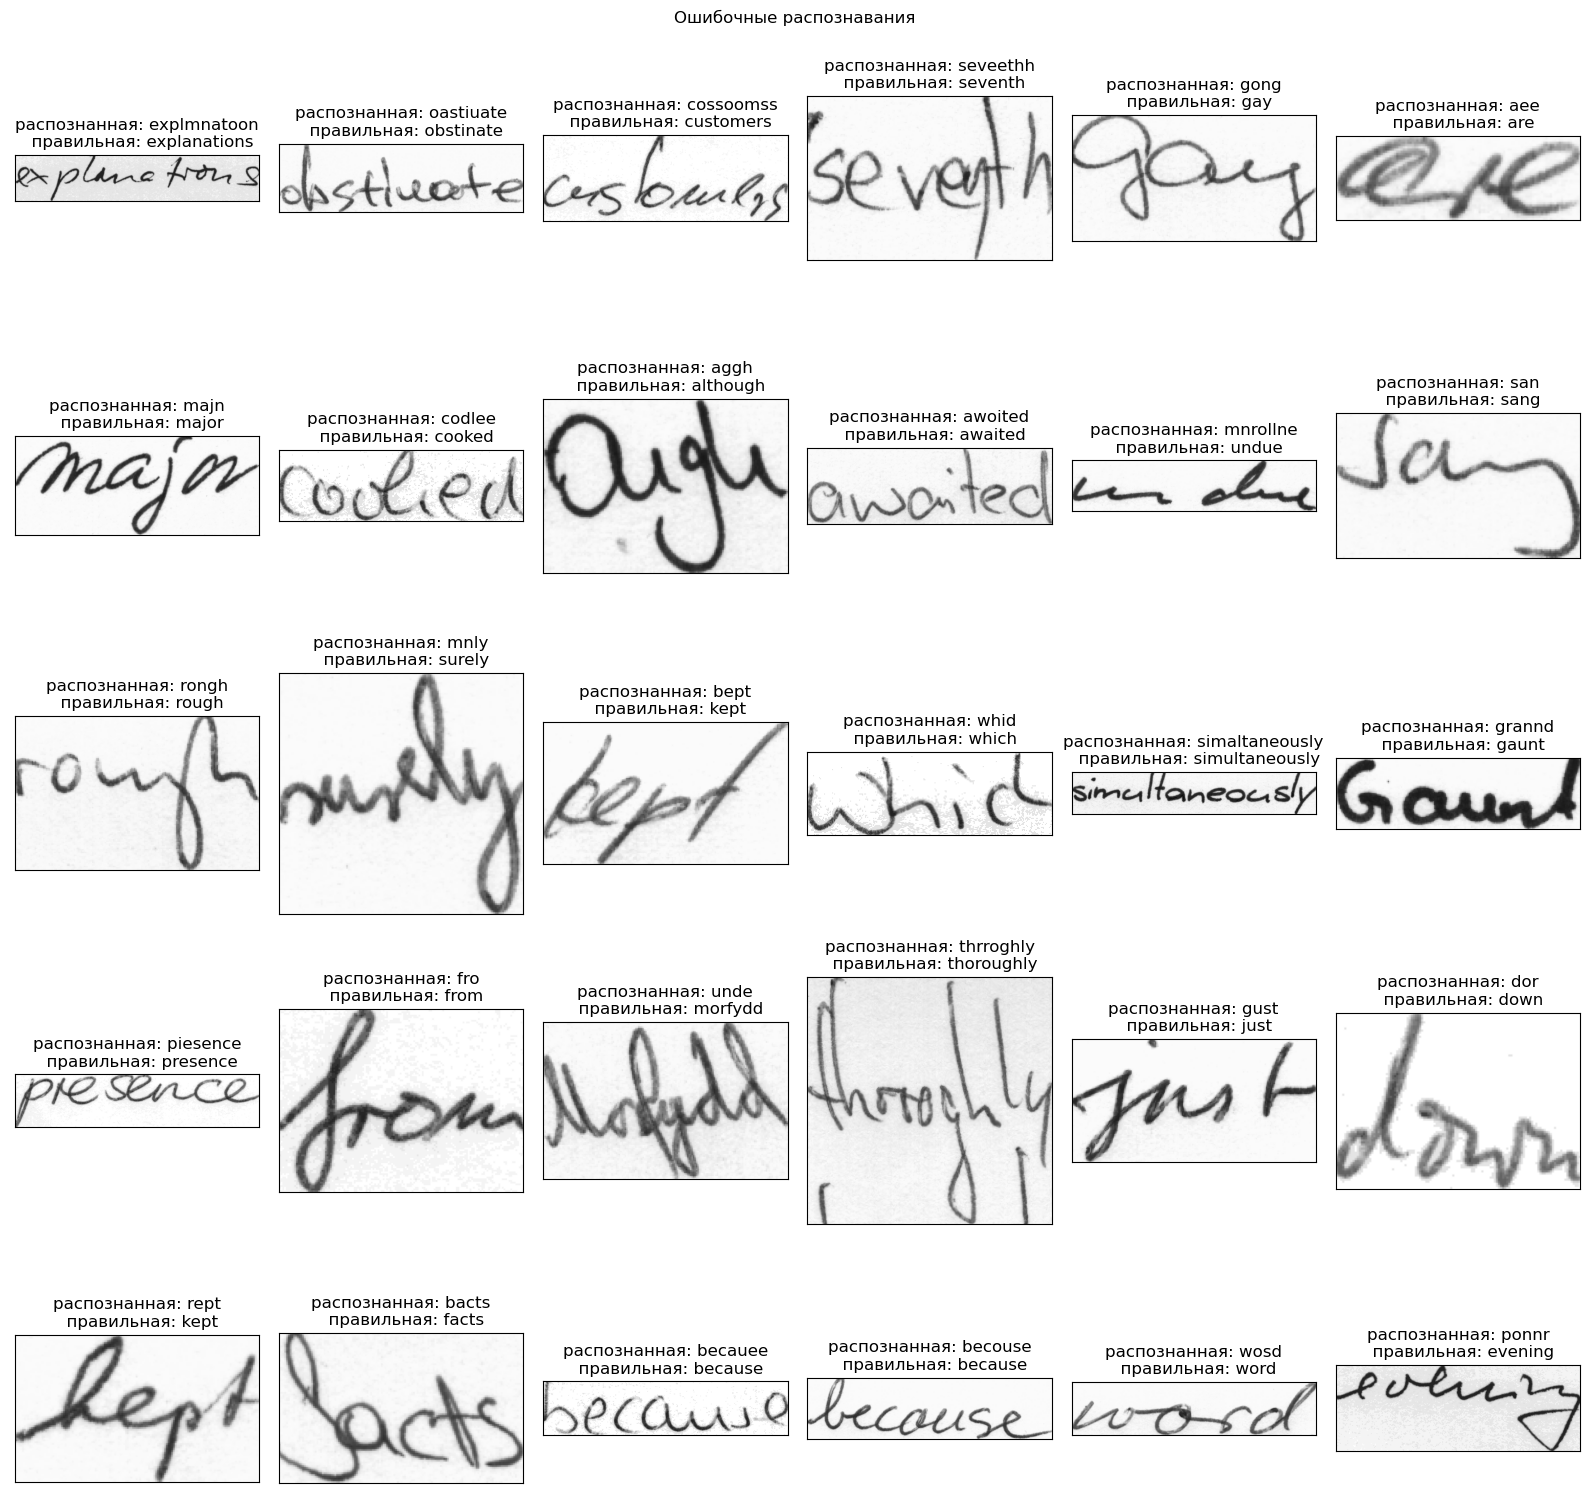

In [32]:
_, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

test_dir = '/home/astrashnov/data/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()